In [1]:
import os
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = 'serif'
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.float_format', '{:.4f}'.format)
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'

In [2]:
import finance
import tradingbot

In [3]:
symbol = 'EUR='
features = [symbol, 'r', 's', 'm', 'v']

In [4]:
a = 0
b = 1750
c = 250

In [5]:
learn_env = finance.Finance(symbol, features, window=20, lags=3,
                            leverage=1, min_performance=0.9, min_accuracy=0.475,
                            start=a, end=a + b, mu=None, std=None)

In [6]:
learn_env.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1750 entries, 2010-02-02 to 2017-01-12
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    1750 non-null   float64
 1   r       1750 non-null   float64
 2   s       1750 non-null   float64
 3   m       1750 non-null   float64
 4   v       1750 non-null   float64
 5   d       1750 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 95.7 KB


In [7]:
valid_env = finance.Finance(symbol, features=learn_env.features,
                            window=learn_env.window, lags=learn_env.lags,
                            leverage=learn_env.leverage,
                            min_performance=0.0, min_accuracy=0.0,
                            start=a + b, end=a + b + c,
                            mu=learn_env.mu, std=learn_env.std)

In [8]:
valid_env.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2017-01-13 to 2018-01-10
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    250 non-null    float64
 1   r       250 non-null    float64
 2   s       250 non-null    float64
 3   m       250 non-null    float64
 4   v       250 non-null    float64
 5   d       250 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.7 KB


In [9]:
tradingbot.set_seeds(100)

In [10]:
agent = tradingbot.TradingBot(24, 0.001, learn_env, valid_env)

In [11]:
episodes = 61

In [10]:
agent.learn(episodes)

episode: 10/61 | VALIDATION | treward:  247 | perf: 1.094 | eps: 0.92
episode: 20/61 | VALIDATION | treward:  247 | perf: 1.089 | eps: 0.83
episode: 30/61 | VALIDATION | treward:  247 | perf: 0.932 | eps: 0.75
episode: 40/61 | VALIDATION | treward:  247 | perf: 1.003 | eps: 0.68
episode: 50/61 | VALIDATION | treward:  247 | perf: 0.998 | eps: 0.62
episode: 60/61 | VALIDATION | treward:  247 | perf: 0.951 | eps: 0.56
episode: 61/61 | treward: 1747 | perf: 1.258 | av: 377.2 | max: 1747
episode: 10/61 | VALIDATION | treward:  247 | perf: 0.932 | eps: 0.50


KeyboardInterrupt: 

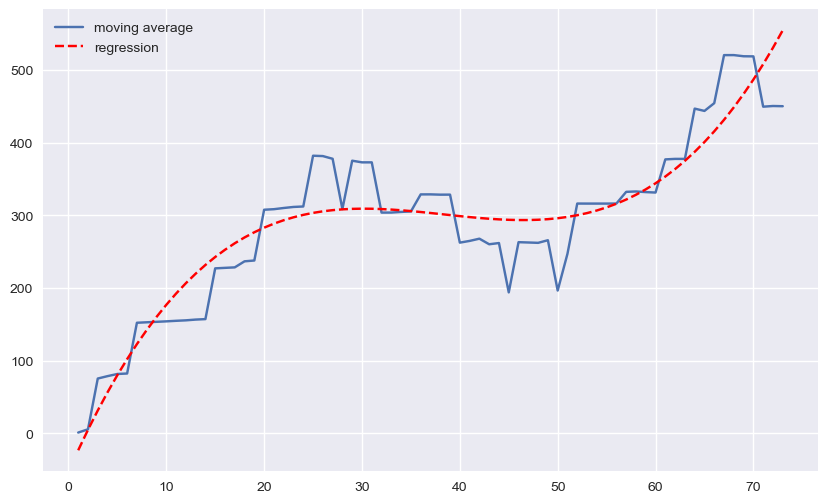

In [11]:
tradingbot.plot_treward(agent)

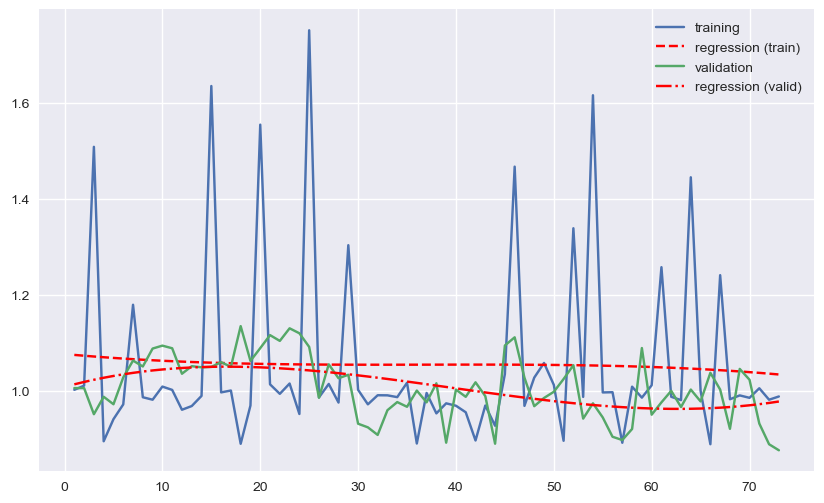

In [12]:
tradingbot.plot_performance(agent)

In [13]:
def reshape(s):
    return np.reshape(s, [1, learn_env.lags,
                          learn_env.n_features])

In [14]:
def backtest(agent, env):
    env.min_accuracy = 0.0
    env.min_performance = 0.0
    done = False
    env.data['p'] = 0
    state = env.reset()
    while not done:
        action = np.argmax(
            agent.model.predict(reshape(state), verbose=0)[0, 0]
        )
        position = 1 if action == 1 else -1
        env.data.loc[:, 'p'].iloc[env.bar] = position
        state, reward, done, info = env.step(action)
    env.data['s'] = env.data['p'] * env.data['r'] * learn_env.leverage

In [15]:
env = agent.learn_env

In [17]:
backtest(agent, env)

In [18]:
env.data['p'].iloc[env.lags:].value_counts()

-1    1124
 1     623
Name: p, dtype: int64

In [19]:
env.data[['r', 's']].iloc[env.lags:].sum().apply(np.exp)

r   0.7725
s   1.7961
dtype: float64

<Axes: xlabel='Date'>

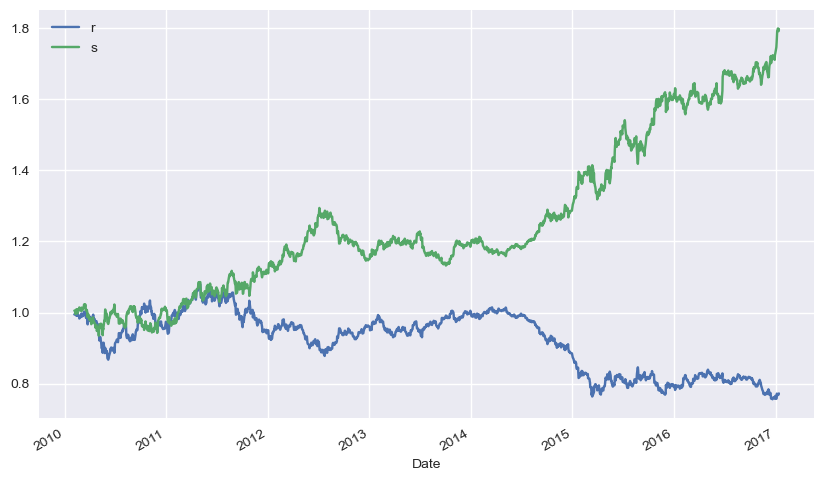

In [20]:
env.data[['r', 's']].iloc[env.lags:].cumsum().apply(np.exp).plot(figsize=(10, 6))

In [21]:
test_env = finance.Finance(symbol, features=learn_env.features,
                           window=learn_env.window,
                           lags=learn_env.lags,
                           leverage=learn_env.leverage,
                           min_performance=0.0, min_accuracy=0.0,
                           start=a + b + c, end=None,
                           mu=learn_env.mu, std=learn_env.std)

In [22]:
env = test_env

In [23]:
backtest(agent, env)

In [24]:
env.data['p'].iloc[env.lags:].value_counts()

-1    436
 1     57
Name: p, dtype: int64

In [25]:
env.data[['r', 's']].iloc[env.lags:].sum().apply(np.exp)

r   0.9144
s   1.0357
dtype: float64

<Axes: xlabel='Date'>

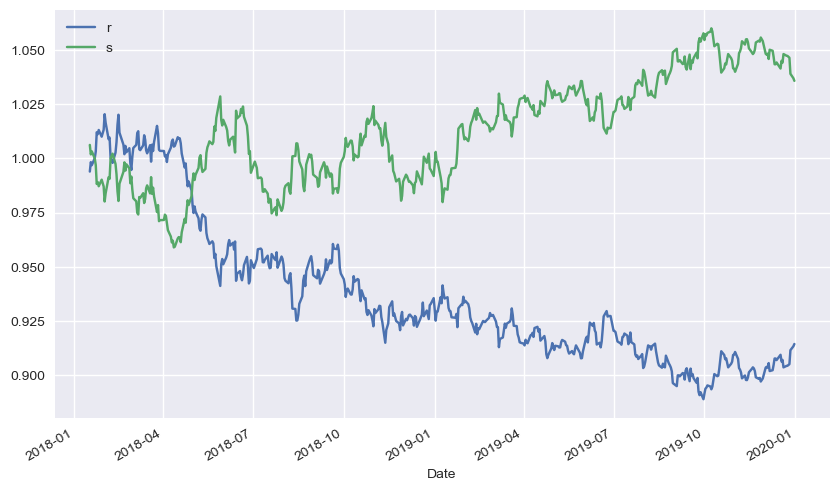

In [26]:
env.data[['r', 's']].iloc[env.lags:].cumsum().apply(np.exp).plot(figsize=(10, 6))

In [27]:
import backtesting as bt

In [28]:
bb = bt.BacktestingBase(env=agent.learn_env, model=agent.model,
                        amount=10000, ptc=0.0001, ftc=1.0,
                        verbose=True)

In [29]:
bb.init_amount

10000

In [30]:
bar = 100

In [31]:
bb.get_date_price(bar)

('2010-06-25', 1.2374)

In [32]:
bb.env.get_state(bar)

,EUR=,r,s,m,v
Date,,,,,
2010-06-22,-0.0242,-0.5622,-0.0916,-0.2022,1.5316
2010-06-23,0.0176,0.6940,-0.0939,-0.0915,1.5563
2010-06-24,0.0354,0.3034,-0.0865,0.6391,1.0890


In [33]:
bb.place_buy_order(bar, amount=5000)

2010-06-25 | buy 4040 units for 1.2374
2010-06-25 | current balance = 4999.40


In [34]:
bb.print_net_wealth(2 * bar)

2010-11-16 | net wealth = 10450.17


In [35]:
bb.place_sell_order(2 * bar, units=1000)

2010-11-16 | sell 1000 units for 1.3492
2010-11-16 | current balance = 6347.47


In [36]:
bb.close_out(3 * bar)

2011-04-11 | ** CLOSING OUT **
2011-04-11 | sell 3040 units for 1.4434
2011-04-11 | current balance = 10733.97
2011-04-11 | net performance [%] = 7.3397
2011-04-11 | number of trades [#] = 3


In [12]:
env = learn_env

In [13]:
from tbbacktester import TBBacktester

In [14]:
tb = TBBacktester(env, agent.model, 10000, 0.0, 0, verbose=False)

In [15]:
tb.backtest_strategy()

2010-02-05 | *** START BACKTEST ***
2010-02-05 | current balance = 10000.00
2017-01-12 | ** CLOSING OUT **
2017-01-12 | current balance = 12274.58
2017-01-12 | net performance [%] = 22.7458
2017-01-12 | number of trades [#] = 2
